<a href="https://colab.research.google.com/github/jeonghojo00/ImageCaptioning/blob/main/2_ImageCaptioning_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0. Initialization

## Connect to Drive

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Change directory to the package folder
%cd '/content/drive/MyDrive/Colab Notebooks/ImageCaptioning/'
# Verify the contents of the current folder
!ls

/content/drive/MyDrive/Colab Notebooks/ImageCaptioning
captions_val2014_fakecap_results.json  inception.py	__pycache__
captions_val2014.json		       inf_result.pkl	resize_image.py
checkpoint			       learned_models	resnet.py
code				       load_data.py	show_attend_tell.py
cs7643-final-project		       lstm_decoder.py	split_caption.py
data				       main.py		util
data_loader.py			       model		utils.py
efficientnet.py			       models		vgg.py
eval.pkl			       models.py	vocab.pkl
experiments			       pretraining.py	vocabulary.py


## Import Libraries

In [ ]:
import sys
import subprocess
import pkg_resources

required = {'efficientnet_pytorch', 'timm', 'pycocoevalcap'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)


In [ ]:
# Import Libraries
import os
from PIL import Image
from tqdm import tqdm
import pickle
import nltk
from collections import Counter

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision import transforms

import torchvision.models as models
from model import (
    encoderCNN,
    decoderRNN
)
from load_data import *
from resize_image import *
from split_caption import *

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Initialize Parameters

In [ ]:
# Define data folder
image_dir = './data/flickr8k/Images' # Original images folder
caption_path = './data/flickr8k/captions.txt' # Original caption file with path

train_image_dir = './data/resized_flickr8k/train/Images' # Resized train images folder
val_image_dir = './data/resized_flickr8k/val/Images' # Resized validation images folder
test_image_dir = './data/resized_flickr8k/test/Images' # Resized test images folder
train_caption_path = "./data/resized_flickr8k/train/captions.txt" # Resized train images' captions
val_caption_path = "./data/resized_flickr8k/val/captions.txt" # Resized validation images' captions
test_caption_path = "./data/resized_flickr8k/test/captions.txt" # Resized test images' captions

resized_image = [256, 256] # Resized image size
num_train_images = 6000
num_val_images = 1000

vocab_path = "./vocab.pkl" # vocabulary file
word_threshold = 4 # Minimum occurrances of words

In [ ]:
# Number of Training data
!wc -l ./data/resized_flickr8k/train/captions.txt
# Number of Validation data
!wc -l ./data/resized_flickr8k/val/captions.txt
# Number of Testing data
!wc -l ./data/resized_flickr8k/test/captions.txt

90000 ./data/resized_flickr8k/train/captions.txt
15000 ./data/resized_flickr8k/val/captions.txt
16365 ./data/resized_flickr8k/test/captions.txt


In [ ]:
def load_encoder(encoder_name, embed_size):
    encoder = None
    if encoder_name == 'ResNet152':
        encoder = encoderCNN.ResNet152(embed_size)
    elif encoder_name == 'Efficientnet':
        encoder = encoderCNN.Efficientnet(embed_size)
    elif encoder_name == "DenseNet161":
        encoder = encoderCNN.DenseNet161(embed_size)
    elif encoder_name == "InceptionV3":
        encoder = encoderCNN.InceptionV3(embed_size)
    elif encoder_name == "GoogleNet":
        encoder = encoderCNN.GoogleNet(embed_size)
    elif encoder_name == "MobileNetV3":
        encoder = encoderCNN.MobileNetV3(embed_size)
    elif encoder_name == "ResNeXt101":
        encoder = encoderCNN.ResNeXt101(embed_size)
    elif encoder_name == "WideResNet101":
        encoder = encoderCNN.WideResNet101(embed_size)
    elif encoder_name == "MNASNet":
        encoder = encoderCNN.MNASNet(embed_size)
    elif encoder_name == "ShuffleNetV2":
        encoder = encoderCNN.ShuffleNetV2(embed_size)
    elif encoder_name == "SqueezeNet":
        encoder = encoderCNN.SqueezeNet(embed_size)
    
    return encoder

In [ ]:
import torch
from torch.nn.utils.rnn import pack_padded_sequence


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

models_path = "./learned_models/" # model path that learned models will be saved
crop_size = 224 # 299 if encoder=="InceptionV3"
vocab_path = "./vocab.pkl" # Preprocessed Vocabulary path

# Make a directory that a learned model will be saved
if not os.path.exists(models_path):
    os.makedirs(models_path)

# Load Vocabulary dictionary (Vocabulary class needs to be defined first)
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)

# Make transforms for training, validating, and testing the model
train_transform = transforms.Compose([ 
    transforms.RandomCrop(crop_size),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

val_transform = transforms.Compose([ 
    transforms.Resize(crop_size), 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

test_transform = transforms.Compose([ 
    transforms.Resize(crop_size), 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

batch_size = 128
num_workers = 2

# Get the dataloaders
train_data_loader = get_loader(train_image_dir, train_caption_path, vocab, train_transform, batch_size, shuffle=True, num_workers=num_workers, testing=False) 
val_data_loader = get_loader(val_image_dir, val_caption_path, vocab, val_transform, batch_size, shuffle=False, num_workers=num_workers, testing=False)
test_data_loader = get_loader(test_image_dir, test_caption_path, vocab, test_transform, batch_size, shuffle=False, num_workers=num_workers, testing=True)

In [ ]:
# Model Hyperparamter
embed_size = 256 # Embedding size for output of encoder and input of decoder
hidden_size = 512 # LSTM hidden states
num_layers = 1 # Number of layers of LSTM

# Declare a decoder
decoder = decoderRNN.DecoderLSTM(embed_size, hidden_size, len(vocab), num_layers).to(device)

num_epochs = 10
learning_rate = 0.001

log_step = 20 # Number of steps to show a log for each batch
save_step = 1000 # Number of steps to save the learned model

# Set loss function
criterion = nn.CrossEntropyLoss()

In [ ]:
encoder_completed = ['ResNet152',
                'Efficientnet',
                'DenseNet161',
                'GoogleNet',
                'MobileNetV3',
                'ResNeXt101',
                'WideResNet101',
                'MNASNet',
                'ShuffleNetV2',
                'SqueezeNet']

# 1. Prediction

## Inference for an image

In [ ]:
def load_image(image_path, transform=None):
    image = Image.open(image_path).convert('RGB')
    image = image.resize([224, 224], Image.LANCZOS)

    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image

image_path = "./data/resized_flickr8k/test/Images/667626_18933d713e.jpg" # Image file for inference
vocab_path = "./vocab.pkl" # path for vocabulary wrapper

# Model parameters (should be same as paramters in train.py)
embed_size = 256 # dimension of word embedding vectors
hidden_size = 512 # dimension of lstm hidden states
num_layers = 1 # number of layers in lstm

In [ ]:
import pickle

# 이미지 전처리(image preprocessing)
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

# Load vocabulary wrapper
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)

# Declare a decoder
decoder = decoderRNN.DecoderLSTM(embed_size, hidden_size, len(vocab), num_layers).to(device)

# Prepare an image
image = load_image(image_path, transform)
image_tensor = image.to(device)

pred_sentences = dict()

for encoder_name in encoder_completed:
    each_model_path = os.path.join(models_path, encoder_name)
    encoder = load_encoder(encoder_name, embed_size).eval()
    encoder = encoder.to(device)
    
    # Load the trained model parameters
    # map_location=torch.device('cpu') added to torch.load if gpu is not available
    encoder_path = os.path.join(each_model_path, "encoder-10.ckpt")
    if device == torch.device('cpu'):
        encoder.load_state_dict(torch.load(encoder_path, map_location=torch.device('cpu')))
    else:
        encoder.load_state_dict(torch.load(encoder_path))
    decoder_path = os.path.join(each_model_path, "decoder-10.ckpt")
    if device == torch.device('cpu'):
        decoder.load_state_dict(torch.load(decoder_path, map_location=torch.device('cpu')))
    else:
        decoder.load_state_dict(torch.load(decoder_path))
    
    # Generate an caption from the image
    feature = encoder(image_tensor)
    sampled_ids = decoder.sample(feature)
    sampled_ids = sampled_ids[0].cpu().numpy() # (1, max_seq_length) -> (max_seq_length)

    # Convert word_ids to words
    sampled_caption = []
    for word_id in sampled_ids: # 하나씩 단어 인덱스를 확인하며
        word = vocab.idx2word[word_id] # 단어 문자열로 바꾸어 삽입
        sampled_caption.append(word)
        if word == '<end>':
            break
    sentence = ' '.join(sampled_caption)
    pred_sentences[encoder_name] = sentence

Loaded pretrained weights for efficientnet-b7


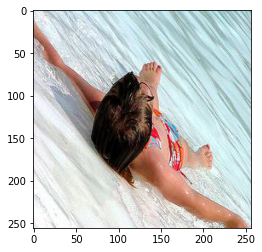

{'DenseNet161': '<start> a little girl is swimming under the crystal blue water . <end>',
 'Efficientnet': '<start> a dog runs in a field . <end>',
 'GoogleNet': '<start> a black dog is leaping into a swimming pool . <end>',
 'MNASNet': '<start> a girl in a bikini running out of the ocean <end>',
 'MobileNetV3': '<start> a dog is in the sand . <end>',
 'ResNeXt101': '<start> two young girls in a swimming suit pool together . <end>',
 'ResNet152': '<start> a girl in a bathing suit is swimming in a pool . <end>',
 'ShuffleNetV2': '<start> a man in a black jacket is holding a microphone toward a young girl with long brown hair .',
 'SqueezeNet': '<start> a young boy wearing a red shirt is standing on the pavement after a red baseball . <end>',
 'WideResNet101': '<start> a girl in a pink bathing suit jumps up from a diving board into a pool . <end>'}

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Print Image with predicted sentences
image = Image.open(image_path)
plt.imshow(np.asarray(image))
plt.show()
pred_sentences

## Predictions with encoders

In [ ]:
predictions = list()
answers = list()
answers_per_image = list()

total_step = len(test_data_loader)
cnt = 0
log_step = 20 

for encoder_name in encoder_completed:
    each_model_path = os.path.join(models_path, encoder_name)
    encoder = load_encoder(encoder_name, embed_size).eval()
    encoder = encoder.to(device)
    
    # Load the trained model parameters
    # map_location=torch.device('cpu') added to torch.load if gpu is not available
    encoder_path = os.path.join(each_model_path, "encoder-10.ckpt")
    if device == torch.device('cpu'):
        encoder.load_state_dict(torch.load(encoder_path, map_location=torch.device('cpu')))
    else:
        encoder.load_state_dict(torch.load(encoder_path))
    decoder_path = os.path.join(each_model_path, "decoder-10.ckpt")
    if device == torch.device('cpu'):
        decoder.load_state_dict(torch.load(decoder_path, map_location=torch.device('cpu')))
    else:
        decoder.load_state_dict(torch.load(decoder_path))

    with torch.no_grad():
        for i, (images, captions, lengths) in enumerate(test_data_loader):
            images = images.to(device)
            captions = captions.to(device)

            # Only Forward
            features = encoder(images)
            sampled_ids_list = decoder.sample(features)

            for index in tqdm(range(len(images))):
                sampled_ids = sampled_ids_list[index].cpu().numpy()

                # Reference(Answer) sentences
                answer = []
                for word_id in captions[index]: # For each caption by index
                    word = vocab.idx2word[word_id.item()] # predicted number into word in the vocabulary
                    answer.append(word)
                    if word == '<end>':
                        break
                answers_per_image.append(answer[1:-1]) # Exclude <sos> and <eos>

                if (cnt + 1) % 5 == 0: # 5 captions for an image
                    answers.append(answers_per_image) # Put all captions into a answer list
                    answers_per_image = []

                    # Predicted sentences
                    prediction = []
                    for word_id in sampled_ids: 
                        word = vocab.idx2word[word_id] 
                        prediction.append(word)
                        if word == '<end>':
                            break
                    predictions.append(prediction[1:-1])
                cnt += 1

            if i % log_step == 0:
                print(f"[ Testing ] Batch size: {i}/{total_step}")
    # Save predictions and answers as pickle files
    predictions_path = os.path.join(each_model_path, "predictions.pkl")
    with open(predictions_path, 'wb') as f:
        pickle.dump(predictions, f)

    answers_path = os.path.join(each_model_path, "answers.pkl")
    with open(answers_path, 'wb') as f:
        pickle.dump(answers, f)   
    print(encoder_name, " completed")

100%|██████████| 128/128 [00:00<00:00, 2610.31it/s]


[ Testing ] Batch size: 0/128


100%|██████████| 128/128 [00:00<00:00, 2388.49it/s]


[ Testing ] Batch size: 20/128


100%|██████████| 128/128 [00:00<00:00, 2383.69it/s]


[ Testing ] Batch size: 40/128


100%|██████████| 128/128 [00:00<00:00, 2357.30it/s]


[ Testing ] Batch size: 60/128


100%|██████████| 128/128 [00:00<00:00, 2099.51it/s]


[ Testing ] Batch size: 80/128


100%|██████████| 128/128 [00:00<00:00, 2167.56it/s]


[ Testing ] Batch size: 100/128


100%|██████████| 128/128 [00:00<00:00, 2976.56it/s]


[ Testing ] Batch size: 120/128


100%|██████████| 109/109 [00:00<00:00, 2674.31it/s]


ShuffleNetV2  completed


100%|██████████| 128/128 [00:00<00:00, 2180.60it/s]


[ Testing ] Batch size: 0/128


100%|██████████| 128/128 [00:00<00:00, 2156.69it/s]


[ Testing ] Batch size: 20/128


100%|██████████| 128/128 [00:00<00:00, 2133.87it/s]


[ Testing ] Batch size: 40/128


100%|██████████| 128/128 [00:00<00:00, 2263.23it/s]


[ Testing ] Batch size: 60/128


100%|██████████| 128/128 [00:00<00:00, 2002.61it/s]


[ Testing ] Batch size: 80/128


100%|██████████| 128/128 [00:00<00:00, 1935.22it/s]


[ Testing ] Batch size: 100/128


100%|██████████| 128/128 [00:00<00:00, 1879.94it/s]


[ Testing ] Batch size: 120/128


100%|██████████| 109/109 [00:00<00:00, 2114.62it/s]


SqueezeNet  completed


#2. Evaluation

## Evaluation with Metrics

In [ ]:
"""
from
https://gist.github.com/kracwarlock/c979b10433fe4ac9fb97
"""

from pycocoevalcap.tokenizer.ptbtokenizer import PTBTokenizer
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.spice.spice import Spice


class COCOEvalCap:
    def __init__(self, images, gts, res):
        self.evalImgs = []
        self.eval = {}
        self.imgToEval = {}
        self.params = {'image_id': images}
        self.gts = gts
        self.res = res

    def evaluate(self):
        imgIds = self.params['image_id']
        gts = self.gts
        res = self.res

        # =================================================
        # Set up scorers
        # =================================================
        print('tokenization...')
        tokenizer = PTBTokenizer()
        gts = tokenizer.tokenize(gts)
        res = tokenizer.tokenize(res)

        # =================================================
        # Set up scorers
        # =================================================
        print('setting up scorers...')
        scorers = [
            (Bleu(4), ["Bleu_1", "Bleu_2", "Bleu_3", "Bleu_4"]),
            (Meteor(), "METEOR"),
            (Rouge(), "ROUGE_L"),
            (Cider(), "CIDEr"),
            (Spice(), "SPICE"),
            #(WMD(),   "WMD"),
        ]

        # =================================================
        # Compute scores
        # =================================================
        eval = {}
        for scorer, method in scorers:
            print('computing %s score...' % (scorer.method()))
            score, scores = scorer.compute_score(gts, res)
            if type(method) == list:
                for sc, scs, m in zip(score, scores, method):
                    self.setEval(sc, m)
                    self.setImgToEvalImgs(scs, imgIds, m)
                    print("%s: %0.3f" % (m, sc))
            else:
                self.setEval(score, method)
                self.setImgToEvalImgs(scores, imgIds, method)
                print("%s: %0.3f" % (method, score))
        self.setEvalImgs()

    def setEval(self, score, method):
        self.eval[method] = score

    def setImgToEvalImgs(self, scores, imgIds, method):
        for imgId, score in zip(imgIds, scores):
            if not imgId in self.imgToEval:
                self.imgToEval[imgId] = {}
                self.imgToEval[imgId]["image_id"] = imgId
            self.imgToEval[imgId][method] = score

    def setEvalImgs(self):
        self.evalImgs = [eval for imgId, eval in self.imgToEval.items()]


def calculate_metrics(rng, datasetGTS, datasetRES):
    imgIds = rng
    gts = {}
    res = {}

    imgToAnnsGTS = {ann['image_id']: [] for ann in datasetGTS['annotations']}
    for ann in datasetGTS['annotations']:
        imgToAnnsGTS[ann['image_id']] += [ann]

    imgToAnnsRES = {ann['image_id']: [] for ann in datasetRES['annotations']}
    for ann in datasetRES['annotations']:
        imgToAnnsRES[ann['image_id']] += [ann]

    for imgId in imgIds:
        gts[imgId] = imgToAnnsGTS[imgId]
        res[imgId] = imgToAnnsRES[imgId]

    evalObj = COCOEvalCap(imgIds, gts, res)
    evalObj.evaluate()
    return evalObj.eval


if __name__ == '__main__':
    rng = range(2)
    datasetGTS = {
        'annotations': [{u'image_id': 0, u'caption': u'the man is playing a guitar'},
                        {u'image_id': 0, u'caption': u'a man is playing a guitar'},
                        {u'image_id': 1, u'caption': u'a woman is slicing cucumbers'},
                        {u'image_id': 1, u'caption': u'the woman is slicing cucumbers'},
                        {u'image_id': 1, u'caption': u'a woman is cutting cucumbers'}]
    }
    datasetRES = {
        'annotations': [{u'image_id': 0, u'caption': u'man is playing guitar'},
                        {u'image_id': 1, u'caption': u'a woman is cutting vegetables'}]
    }
    print(calculate_metrics(rng, datasetGTS, datasetRES))


tokenization...
setting up scorers...
Progress: 384.5M / 384.5M (100.0%)
Extracting stanford-corenlp-3.6.0 ...
Done.
computing Bleu score...
{'testlen': 9, 'reflen': 11, 'guess': [9, 7, 5, 3], 'correct': [8, 5, 3, 1]}
ratio: 0.8181818181074382
Bleu_1: 0.712
Bleu_2: 0.638
Bleu_3: 0.580
Bleu_4: 0.478
computing METEOR score...
METEOR: 0.402
computing Rouge score...
ROUGE_L: 0.786
computing CIDEr score...
CIDEr: 4.017
computing SPICE score...
SPICE: 0.667
{'Bleu_1': 0.711766580212326, 'Bleu_2': 0.638042834868279, 'Bleu_3': 0.5804707570883624, 'Bleu_4': 0.47799953528030814, 'METEOR': 0.40192687755977896, 'ROUGE_L': 0.7860759493670886, 'CIDEr': 4.016678075227614, 'SPICE': 0.6666666666666666}


In [ ]:
def convert4eval(predictions, answers):
    id_count = 0
    ref = dict()
    ref['annotations'] = list()

    pred = dict()
    pred['annotations'] = list()

    for i in range(len(predictions)):
        for j in range(len(answers[i])):
            ref4img = dict()
            ref4img['image_id'] = i
            answer_caption = answers[i][j]
            answer_caption = ' '.join(answer_caption)
            ref4img['caption'] = answer_caption
            ref['annotations'].append(ref4img)
        pred4img = dict()
        pred4img['image_id'] = i
        pred_caption = predictions[i]
        pred_caption = ' '.join(pred_caption)
        pred4img['caption'] = pred_caption
        pred['annotations'].append(pred4img)

    return pred, ref

In [ ]:
evaluation_metrics = dict()

for encoder_name in encoder_completed:
    print("...Evaluating ", encoder_name, " ...")
    each_model_path = os.path.join(models_path, encoder_name)
    prediction_path = os.path.join(each_model_path, "predictions.pkl")
    answer_path = os.path.join(each_model_path, "answers.pkl")

    with open(prediction_path, 'rb') as f:
        predictions = pickle.load(f)
    with open(answer_path, 'rb') as f:
        answers = pickle.load(f)
    
    pred, ref = convert4eval(predictions, answers)
    rng = range(len(pred['annotations']))
    eval_result = calculate_metrics(rng, ref, pred)

    evaluation_metrics[encoder_name] = eval_result



In [ ]:
eval_path = "./eval.pkl"
with open(eval_path, 'wb') as f:
    pickle.dump(evaluation_metrics, f)

## Load Evaluation file

In [ ]:
import matplotlib.pyplot as plt

def getBarChart(evaluation_result,chart_title,chart_size=(10,5)):
    x = list(evaluation_result.keys())
    y = evaluation_result.values()

    plt.figure(figsize=chart_size)
    plt.title(chart_title)
    plt.barh(x, y)
    for index, value in enumerate(y):
        plt.text(value, index,
                str(value))
    plt.show()

In [ ]:
import pickle

eval_path = "./eval.pkl"
eval_result = pickle.load( open(eval_path, "rb" ) )

In [ ]:
spice_score = dict()
rough_l_score = dict()
meteor_score = dict()
bleu_4_score = dict()

for encoder in eval_result.keys():
    spice_score[encoder] = round(eval_result[encoder]['SPICE'],3)
    rough_l_score[encoder] = round(eval_result[encoder]['ROUGE_L'],3)
    meteor_score[encoder] = round(eval_result[encoder]['METEOR'],3)
    bleu_4_score[encoder] = round(eval_result[encoder]['Bleu_4'],3)

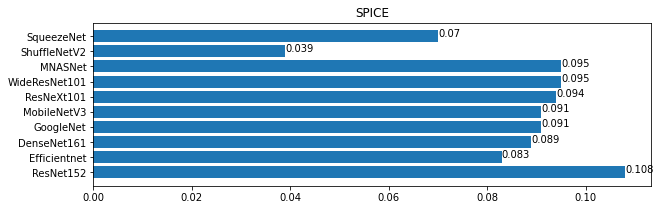

In [ ]:
getBarChart(spice_score,chart_title='SPICE',chart_size=(10,3))

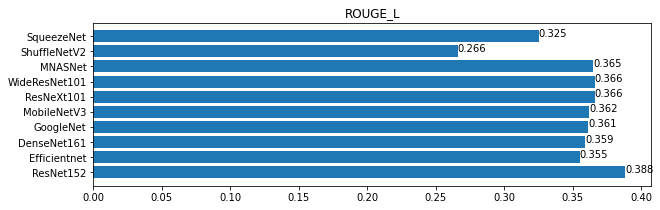

In [ ]:
getBarChart(rough_l_score,chart_title='ROUGE_L',chart_size=(10,3))

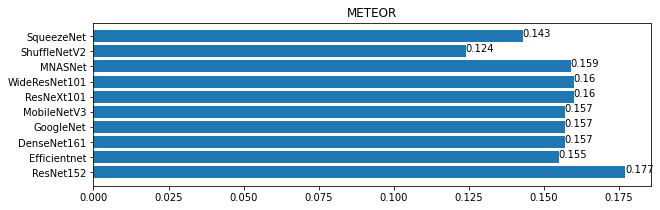

In [ ]:
getBarChart(meteor_score,chart_title='METEOR',chart_size=(10,3))

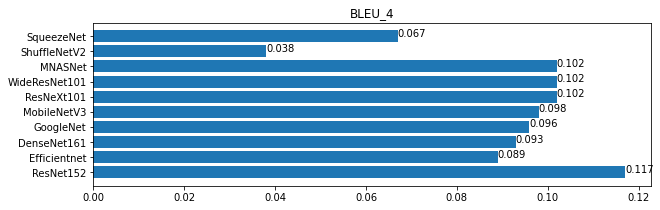

In [ ]:
getBarChart(bleu_4_score,chart_title='BLEU_4',chart_size=(10,3))

#3. Inference with encoders

In [ ]:
import torch
import pickle
from torchvision import transforms
from model import (
    encoderCNN,
    decoderRNN
)

# 모델 하이퍼 파라미터 설정
embed_size = 256 # 임베딩(embedding) 차원
hidden_size = 512 # LSTM hidden states 차원
num_layers = 1 # LSTM의 레이어 개수
vocab_path = "./vocab.pkl" # vocabulary file
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 이미지 전처리(image preprocessing)
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

# Load vocabulary wrapper
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)

# Declare a decoder
decoder = decoderRNN.DecoderLSTM(embed_size, hidden_size, len(vocab), num_layers).to(device)

def getPredictions(img_path):
    # Prepare an image
    image = load_image(img_path, transform)
    image_tensor = image.to(device)

    pred_sentences = dict()

    for encoder_name in encoder_completed:
        each_model_path = os.path.join(models_path, encoder_name)
        encoder = load_encoder(encoder_name, embed_size).eval()
        encoder = encoder.to(device)
        
        # Load the trained model parameters
        # map_location=torch.device('cpu') added to torch.load if gpu is not available
        encoder_path = os.path.join(each_model_path, "encoder-10.ckpt")
        if device == torch.device('cpu'):
            encoder.load_state_dict(torch.load(encoder_path, map_location=torch.device('cpu')))
        else:
            encoder.load_state_dict(torch.load(encoder_path))
        decoder_path = os.path.join(each_model_path, "decoder-10.ckpt")
        if device == torch.device('cpu'):
            decoder.load_state_dict(torch.load(decoder_path, map_location=torch.device('cpu')))
        else:
            decoder.load_state_dict(torch.load(decoder_path))
        
        # Generate an caption from the image
        feature = encoder(image_tensor)
        sampled_ids = decoder.sample(feature)
        sampled_ids = sampled_ids[0].cpu().numpy() # (1, max_seq_length) -> (max_seq_length)

        # Convert word_ids to words
        sampled_caption = []
        for word_id in sampled_ids: # 하나씩 단어 인덱스를 확인하며
            word = vocab.idx2word[word_id] # 단어 문자열로 바꾸어 삽입
            sampled_caption.append(word)
            if word == '<end>':
                break
        sentence = ' '.join(sampled_caption)
        pred_sentences[encoder_name] = sentence
    return pred_sentences

In [ ]:
# Randomly pick 10 images from test image directory
import os
import random 

test_image_dir = './data/resized_flickr8k/test/Images' # Resized test images folder
files=os.listdir(test_image_dir)
rand_imgs = random.choices(files, k=10)

Loaded pretrained weights for efficientnet-b7


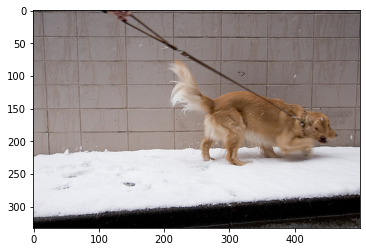

ResNet152 :  <start> a dog is running past a chain link fence . <end>
Efficientnet :  <start> a brown dog is running in the grass between obstacles on a course <end>
DenseNet161 :  <start> a brown dog is running through snowy woodland . <end>
GoogleNet :  <start> a dog is running through a tunnel <end>
MobileNetV3 :  <start> a dog is on the bed holding a toy soccer ball . <end>
ResNeXt101 :  <start> a brown dog is running through the snow . <end>
WideResNet101 :  <start> a dog is running down a wooden staircase . <end>
MNASNet :  <start> a dog jumps over a bar with a ball in its mouth . <end>
ShuffleNetV2 :  <start> a man in a black jacket is holding a microphone toward a young girl with long brown hair .
SqueezeNet :  <start> a brown dog is running across a low cut field of another with a furry tree . <end>
Loaded pretrained weights for efficientnet-b7


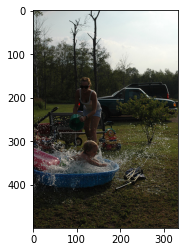

ResNet152 :  <start> a boy and a girl are playing in a pool in a park . <end>
Efficientnet :  <start> a man in a green t-shirt is skateboarding along a graffiti covered wall in front of a blue door
DenseNet161 :  <start> a boy in a yellow life vest jumping into a pool . <end>
GoogleNet :  <start> a man is kayaking in the ocean on a beach . <end>
MobileNetV3 :  <start> a boy in a red shirt and a boy in a yellow shirt are jumping on a trampoline outside
ResNeXt101 :  <start> a man in a yellow shirt and a girl in a blue shirt are smiling while wearing a brown
WideResNet101 :  <start> a young boy and girl are playing in a mud puddle . <end>
MNASNet :  <start> a girl in a bathing suit plays on the surf . <end>
ShuffleNetV2 :  <start> a man in a black jacket is holding a microphone toward a young girl with long brown hair .
SqueezeNet :  <start> a man is riding a bike through a wooded area near some trees . <end>
Loaded pretrained weights for efficientnet-b7


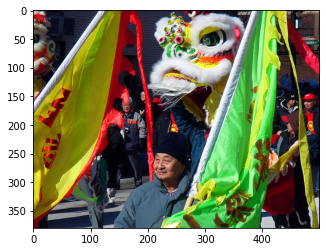

ResNet152 :  <start> a man in a green jacket holding a small child on a rope . <end>
Efficientnet :  <start> a man in a green shirt is skating on a railing . <end>
DenseNet161 :  <start> a row of people is marching in the sand in front of a <unk> building . <end>
GoogleNet :  <start> a group of people are looking at the view of a large building . <end>
MobileNetV3 :  <start> a man is sitting at an outside bar near many soda and beer cans . <end>
ResNeXt101 :  <start> a group of children in a church <unk> play <unk> and <unk> . <end>
WideResNet101 :  <start> a young girl wearing a blue leotard jumps in the air while playing in the snow . <end>
MNASNet :  <start> a little girl in a red snowsuit sits on a snowball in a backyard . <end>
ShuffleNetV2 :  <start> a man in a black jacket is holding a microphone toward a young girl with long brown hair .
SqueezeNet :  <start> a child is standing on the side of a street with their backs to the large brown and white
Loaded pretrained weights for 

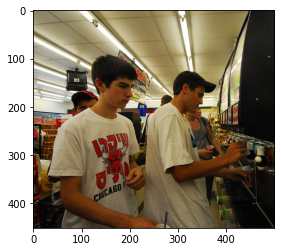

ResNet152 :  <start> a man in a suit is standing in a stadium with a <unk> in sign . <end>
Efficientnet :  <start> a man in a white shirt is standing in a tent holding a <unk> or guitar . <end>
DenseNet161 :  <start> a man is holding up a plastic jug indoors . <end>
GoogleNet :  <start> a man in a white shirt is standing in a <unk> store with a crowd behind him . <end>
MobileNetV3 :  <start> a man wearing a cowboy hat and a gold cross around his neck <end>
ResNeXt101 :  <start> a man in a blue shirt is operating a <unk> while another man looks on . <end>
WideResNet101 :  <start> a man in a black jacket is standing beside the woman holding a cup and is wearing a hat
MNASNet :  <start> a man is standing behind and desk and there is part of a red car hanging above his head
ShuffleNetV2 :  <start> a man in a black jacket is holding a microphone toward a young girl with long brown hair .
SqueezeNet :  <start> a man with a guitar holds a child who is sitting behind him . <end>
Loaded pretrai

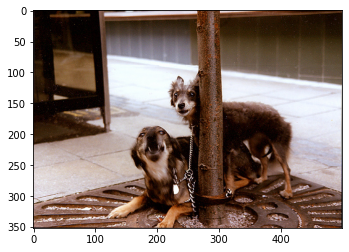

ResNet152 :  <start> a dog is looking at a tennis ball . <end>
Efficientnet :  <start> a man in a green shirt climbs an indoor climbing wall . <end>
DenseNet161 :  <start> a brown dog is looking at a black horse that is sticking its head through a fence . <end>
GoogleNet :  <start> a dog jumps over a hurdle in the grass . <end>
MobileNetV3 :  <start> a young boy is playing in the water . <end>
ResNeXt101 :  <start> a dog is bringing a man on a stick . <end>
WideResNet101 :  <start> a black and white dog is <unk> whilst catching a yellow ball in his mouth . <end>
MNASNet :  <start> a dog jumps off a wooden porch . <end>
ShuffleNetV2 :  <start> a man in a black jacket is holding a microphone toward a young girl with long brown hair .
SqueezeNet :  <start> a brown and black dog sitting on a bench . <end>
Loaded pretrained weights for efficientnet-b7


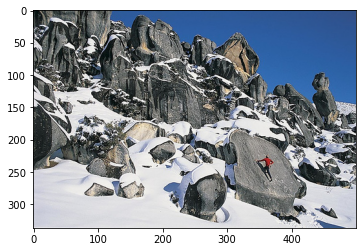

ResNet152 :  <start> people are standing on a snow covered hill watching the mountain range . <end>
Efficientnet :  <start> a person in a black jacket is snowboarding during the evening . <end>
DenseNet161 :  <start> a group of people are standing on a ledge overlooking low clouds . <end>
GoogleNet :  <start> a group of people are standing in the snow with brooms . <end>
MobileNetV3 :  <start> a group of people stand in the snow in a mountain . <end>
ResNeXt101 :  <start> a group of people are standing in front of a mountain scene in the snow . <end>
WideResNet101 :  <start> a skier is coming down a hill . <end>
MNASNet :  <start> a person stands in the snow at the bottom of a snow covered mountain . <end>
ShuffleNetV2 :  <start> a man in a black jacket is holding a microphone toward a young girl with long brown hair .
SqueezeNet :  <start> a person is on a snowboard with a snowboard in the air . <end>
Loaded pretrained weights for efficientnet-b7


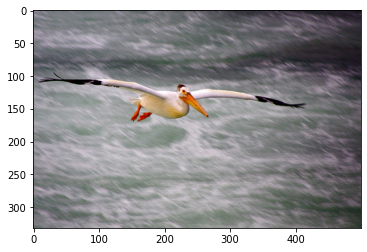

ResNet152 :  <start> a man in a wetsuit <unk> water . <end>
Efficientnet :  <start> a man in a wetsuit is surfing on a green surfboard . <end>
DenseNet161 :  <start> a man hangs from one while another man watches . <end>
GoogleNet :  <start> a man is kayaking down a waterfall . <end>
MobileNetV3 :  <start> a man in a wetsuit is surfing on a green surfboard . <end>
ResNeXt101 :  <start> a group of people swimming in a lake <end>
WideResNet101 :  <start> a man in a swimsuit is doing a back flip off a rock whilst another boy watching . <end>
MNASNet :  <start> a young boy in a black wetsuit is surfing . <end>
ShuffleNetV2 :  <start> a man in a black jacket is holding a microphone toward a young girl with long brown hair .
SqueezeNet :  <start> a dog swims in a lake . <end>
Loaded pretrained weights for efficientnet-b7


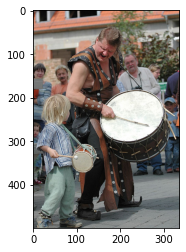

ResNet152 :  <start> a man wearing a white shirt and tie is playing a game of french games in a green sports
Efficientnet :  <start> a man in a green shirt is skating on a railing . <end>
DenseNet161 :  <start> a man with a blue coat and a red hat is holding up a sign . <end>
GoogleNet :  <start> a man in a black shirt and jeans stands in front of a building playing a game . <end>
MobileNetV3 :  <start> a man wearing a black shirt and a girl wearing an orange shirt sitting on the pavement eating .
ResNeXt101 :  <start> a man with a <unk> pop and a woman wearing a black jacket and white hat in a crowd
WideResNet101 :  <start> a man in a red shirt stands next to a blue and white wall in a parking lot .
MNASNet :  <start> a man in a blue jacket lifts a child dressed in red out boat crowded with people <end>
ShuffleNetV2 :  <start> a man in a black jacket is holding a microphone toward a young girl with long brown hair .
SqueezeNet :  <start> a group of basketball players in front of a <un

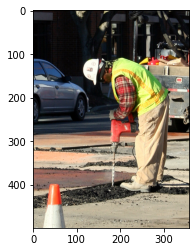

ResNet152 :  <start> a man in a black hoodie is holding a <unk> and shopping cart . <end>
Efficientnet :  <start> a man in a green shirt is skating on a railing . <end>
DenseNet161 :  <start> a man in a blue shirt is walking barefoot . <end>
GoogleNet :  <start> a man in a yellow jacket is riding a bicycle in the street . <end>
MobileNetV3 :  <start> a young girl is walking up a steep grassy hill . <end>
ResNeXt101 :  <start> a boy wearing a yellow shirt and blue pants is holding a cup in the air . <end>
WideResNet101 :  <start> a woman in a red jacket and orange glasses is jogging . <end>
MNASNet :  <start> a boy in a blue shirt is posing in front of an igloo type building with a person dangling
ShuffleNetV2 :  <start> a man in a black jacket is holding a microphone toward a young girl with long brown hair .
SqueezeNet :  <start> a man is sitting in front of a orange race car . <end>
Loaded pretrained weights for efficientnet-b7


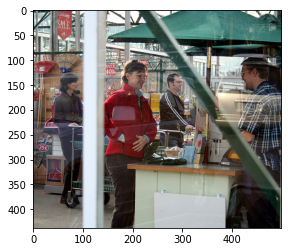

ResNet152 :  <start> a man in a blue coat and red hat is standing in front of a bar with a beer
Efficientnet :  <start> a man with a <unk> haircut is waiting to catch a child that he has thrown into the air
DenseNet161 :  <start> a man in a hat at a protest is looking down . <end>
GoogleNet :  <start> a man in a red shirt is standing at the foot of a coffee shop . <end>
MobileNetV3 :  <start> a man is sitting on a couch holding a baby while surrounded by children . <end>
ResNeXt101 :  <start> a man in a red jacket and hat talks to another man . <end>
WideResNet101 :  <start> a man in a red jacket is standing in front of a sign selling <unk> . <end>
MNASNet :  <start> a young boy jumping and a young girl seating in an inflatable pool <end>
ShuffleNetV2 :  <start> a man in a black jacket is holding a microphone toward a young girl with long brown hair .
SqueezeNet :  <start> people are standing on the curb of a large city . <end>


In [ ]:
img_paths = list()
inf_result = dict()

for img in rand_imgs:
    img_path = os.path.join(image_dir, img)
    pred_sentences = getPredictions(img_path)
    inf_result[img] = pred_sentences
    
    image = Image.open(img_path)
    plt.imshow(np.asarray(image))
    plt.show()

    for encoder in pred_sentences.keys():
        print(encoder, ": ", pred_sentences[encoder])
    

In [ ]:
inf_path = "./inf_result.pkl"
with open(inf_path, 'wb') as f:
    pickle.dump(evaluation_metrics, f)

In [ ]:
import pickle

inf_path = "./inf_result.pkl"
inf_result = pickle.load( open(inf_path, "rb" ) )

In [ ]:
for each_img in list(inf_result.keys()):
    print(each_img)

396179143_e1511336e1.jpg
973827791_467d83986e.jpg
394563330_68b566368c.jpg
783994497_4f6885454d.jpg
468871328_72990babd4.jpg
478209058_21e2c37c73.jpg
3719461451_07de35af3a.jpg
757046028_ff5999f91b.jpg
405961988_fcfe97f31e.jpg
393987665_91d28f0ed0.jpg


In [ ]:
predictions_path = "./learned_models/ResNet152/predictions.pkl"

with open(predictions_path, 'rb') as f:
    predictions = pickle.load(f)

answers_path = "./learned_models/ResNet152/answers.pkl"
with open(answers_path, 'rb') as f:
    answers = pickle.load(f)

print("예측한 문장의 수:", len(predictions))
print("정답 문장 집합의 수 (5개씩):", len(answers))

index = 10
print("[ 정답 캡션들 ]")
for answer in answers[index]:
    print(answer)

print("[ 예측된 캡션 ]")
print(predictions[index])